<a target="_blank" href="https://colab.research.google.com/github/nz-gravity/sgvb_psd/blob/main/docs/examples/lisa_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# LISA Example

Running the PSD estimator on LISA data from https://zenodo.org/records/15698080



In [1]:
! pip install sgvb_psd -q 

# %load_ext autoreload
# %autoreload 2
%matplotlib inline

saving to data\tdi.h5


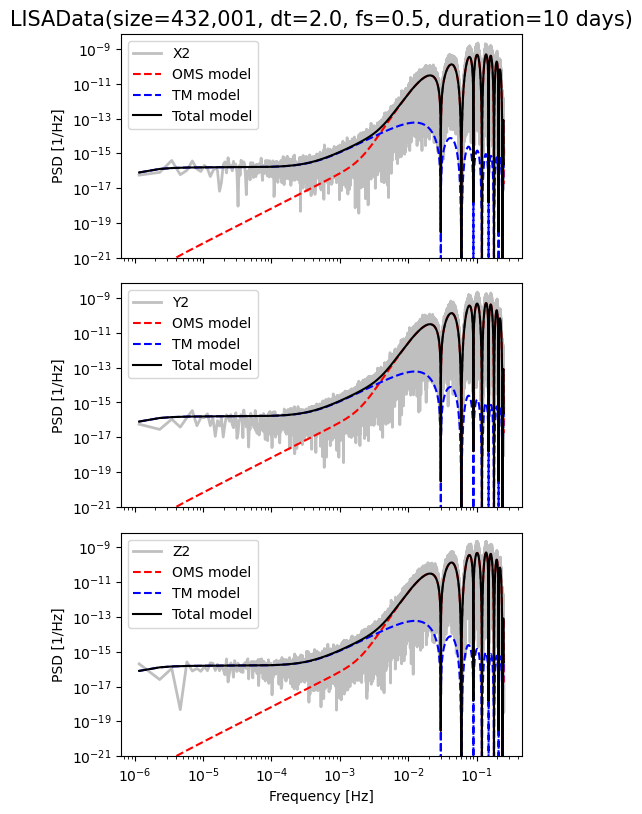

In [2]:
import dataclasses
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)


def download(url: str, dest_folder: str):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # create folder if it does not exist

    filename = url.split("/")[-1].replace(
        " ", "_"
    )  # be careful with file names
    file_path = os.path.join(dest_folder, filename)

    r = requests.get(url, stream=True)
    if r.ok:
        print("saving to", file_path)
        with open(file_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 8):
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
    else:  # HTTP status code 4XX/5XX
        print(
            "Download failed: status code {}\n{}".format(r.status_code, r.text)
        )



def testmass_noise_asd(
        freq,
        asd=2.4e-15,
        fknee=4e-4,
        central_freq=2.81e14,
        duration=365.25 * 24 * 3600,
        fs=0.5,
):
    """
    Test mass noise ASD in TMI carrier beatnote fluctuations.

    Args:
        freq (array): frequencies [Hz]
        asd (float): test mass acceleration noise ASD [m/s^2/√Hz]
        fknee (float): knee frequency [Hz]
        central_freq (float): laser central frequency [Hz]
        duration (float): observation duration [s]
        fs (float): sampling frequency [Hz]

    Returns:
        array: noise ASD [Hz/√Hz]
    """
    c = 299792458  # speed of light [m/s]
    fmin = 1.0 / duration

    # High frequency component
    psd_highfreq = (
            (2 * asd * central_freq / (2 * np.pi * c)) ** 2
            * np.abs(
        (2 * np.pi * fmin)
        / (
                1
                - np.exp(-2 * np.pi * fmin / fs)
                * np.exp(-2j * np.pi * freq / fs)
        )
    )
            ** 2
            * 1
            / (fs * fmin) ** 2
    )

    # Low frequency component
    psd_lowfreq = (
            (2 * asd * central_freq * fknee / (2 * np.pi * c)) ** 2
            * np.abs(
        (2 * np.pi * fmin)
        / (
                1
                - np.exp(-2 * np.pi * fmin / fs)
                * np.exp(-2j * np.pi * freq / fs)
        )
    )
            ** 2
            * 1
            / (fs * fmin) ** 2
            * np.abs(1 / (1 - np.exp(-2j * np.pi * freq / fs))) ** 2
            * (2 * np.pi / fs) ** 2
    )

    return np.sqrt(psd_lowfreq + psd_highfreq)


def oms_noise_asd(
        freq,
        asd=7.9e-12,
        fknee=2e-3,
        central_freq=2.81e14,
        duration=365.25 * 24 * 3600,
        fs=0.5,
):
    """
    OMS noise ASD in ISI carrier beatnote fluctuations.

    Args:
        freq (array): frequencies [Hz]
        asd (float): OMS displacement noise ASD [m/√Hz]
        fknee (float): knee frequency [Hz]
        central_freq (float): laser central frequency [Hz]
        duration (float): observation duration [s]
        fs (float): sampling frequency [Hz]

    Returns:
        array: noise ASD [Hz/√Hz]
    """
    c = 299792458  # speed of light [m/s]
    fmin = 1.0 / duration

    # High frequency component
    psd_highfreq = (asd * fs * central_freq / c) ** 2 * np.sin(
        2 * np.pi * freq / fs
    ) ** 2

    # Low frequency component
    psd_lowfreq = (
            (2 * np.pi * asd * central_freq * fknee ** 2 / c) ** 2
            * np.abs(
        (2 * np.pi * fmin)
        / (
                1
                - np.exp(-2 * np.pi * fmin / fs)
                * np.exp(-2j * np.pi * freq / fs)
        )
    )
            ** 2
            * 1
            / (fs * fmin) ** 2
    )

    return np.sqrt(psd_highfreq + psd_lowfreq)


def tdi_transfer_functions(freq, armlength=2.5e9):
    """
    TDI transfer functions for test mass and OMS noise.

    Args:
        freq (array): frequencies [Hz]
        armlength (float): LISA arm length [m]

    Returns:
        tuple: (tf_testmass, tf_oms) - transfer function amplitudes
    """
    c = 299792458  # speed of light [m/s]
    L = armlength / c  # arm length in seconds

    # Common TDI factor
    common = (
            16
            * np.sin(2 * np.pi * freq * L) ** 2
            * np.sin(4 * np.pi * freq * L) ** 2
    )

    # Test mass transfer function
    tf_testmass = np.sqrt(common * (3 + np.cos(4 * np.pi * freq * L)))

    # OMS transfer function
    tf_oms = np.sqrt(4 * common)

    return tf_testmass, tf_oms


def TM_model(
        freq,
        tm_asd=2.4e-15,
        tm_fknee=4e-4,
        central_freq=2.81e14,
        duration=365.25 * 24 * 3600,
        fs=0.5,
        armlength=2.5e9,
):
    """
    Complete test mass noise model in TDI.

    Args:
        freq (array): frequencies [Hz]
        tm_asd (float): test mass acceleration noise ASD [m/s^2/√Hz]
        tm_fknee (float): test mass knee frequency [Hz]
        central_freq (float): laser central frequency [Hz]
        duration (float): observation duration [s]
        fs (float): sampling frequency [Hz]
        armlength (float): LISA arm length [m]

    Returns:
        array: TDI test mass noise ASD [Hz/√Hz]
    """
    noise_asd = testmass_noise_asd(
        freq, tm_asd, tm_fknee, central_freq, duration, fs
    )
    tf_testmass, _ = tdi_transfer_functions(freq, armlength)
    return tf_testmass * noise_asd


def OMS_model(
        freq,
        oms_asd=7.9e-12,
        oms_fknee=2e-3,
        central_freq=2.81e14,
        duration=365.25 * 24 * 3600,
        fs=0.5,
        armlength=2.5e9,
):
    """
    Complete OMS noise model in TDI.

    Args:
        freq (array): frequencies [Hz]
        oms_asd (float): OMS displacement noise ASD [m/√Hz]
        oms_fknee (float): OMS knee frequency [Hz]
        central_freq (float): laser central frequency [Hz]
        duration (float): observation duration [s]
        fs (float): sampling frequency [Hz]
        armlength (float): LISA arm length [m]

    Returns:
        array: TDI OMS noise ASD [Hz/√Hz]
    """
    noise_asd = oms_noise_asd(
        freq, oms_asd, oms_fknee, central_freq, duration, fs
    )
    _, tf_oms = tdi_transfer_functions(freq, armlength)
    return tf_oms * noise_asd


def Total_model(
        freq,
        tm_asd=2.4e-15,
        tm_fknee=4e-4,
        oms_asd=7.9e-12,
        oms_fknee=2e-3,
        central_freq=2.81e14,
        duration=365.25 * 24 * 3600,
        fs=0.5,
        armlength=2.5e9,
):
    """
    Total noise model combining test mass and OMS noise in TDI.

    Args:
        freq (array): frequencies [Hz]
        tm_asd (float): test mass acceleration noise ASD [m/s^2/√Hz]
        tm_fknee (float): test mass knee frequency [Hz]
        oms_asd (float): OMS displacement noise ASD [m/√Hz]
        oms_fknee (float): OMS knee frequency [Hz]
        central_freq (float): laser central frequency [Hz]
        duration (float): observation duration [s]
        fs (float): sampling frequency [Hz]
        armlength (float): LISA arm length [m]

    Returns:
        array: Total TDI noise ASD [Hz/√Hz]
    """
    tm_model = TM_model(
        freq, tm_asd, tm_fknee, central_freq, duration, fs, armlength
    )
    oms_model = OMS_model(
        freq, oms_asd, oms_fknee, central_freq, duration, fs, armlength
    )
    return np.sqrt(tm_model ** 2 + oms_model ** 2)


@dataclasses.dataclass
class LISAData:
    t: np.ndarray
    x2: np.ndarray
    y2: np.ndarray
    z2: np.ndarray
    t0: float = dataclasses.field(init=False)
    size: int = dataclasses.field(init=False)
    dt: float = dataclasses.field(init=False)
    fs: float = dataclasses.field(init=False)
    data: np.ndarray = dataclasses.field(init=False)
    duration: float = dataclasses.field(init=False)
    oms_model: np.ndarray = None
    tm_model: np.ndarray = None
    total_model: np.ndarray = None

    def __post_init__(self):
        self.update_models()

    def update_models(self, **kwargs):
        self.size = len(self.t)
        self.t0 = self.t[0]
        self.dt = self.t[1] - self.t0
        self.fs = 1 / self.dt
        self.duration = self.size * self.dt
        freq = np.fft.rfftfreq(self.size, d=self.dt)
        self.oms_model = OMS_model(
            freq, duration=self.duration, fs=self.fs, **kwargs
        )
        self.tm_model = TM_model(
            freq, duration=self.duration, fs=self.fs, **kwargs
        )
        self.total_model = Total_model(
            freq, duration=self.duration, fs=self.fs, **kwargs
        )
        self.data = np.vstack([self.x2, self.y2, self.z2]).T

    @classmethod
    def from_hdf5(cls, filename: str):
        with h5py.File(filename, "r") as f:
            t = np.array(f["t"][:])
            x2 = np.array(f["X2"][:])
            y2 = np.array(f["Y2"][:])
            z2 = np.array(f["Z2"][:])
            return cls(t=t, x2=x2, y2=y2, z2=z2)

    # overide the [:] operator to return a truncated version of the data
    def __getitem__(self, key):
        if isinstance(key, slice):
            # ensure that the slice is valid
            start = key.start or 0
            stop = key.stop or self.size
            step = key.step or 1
            if start < 0 or stop > self.size or step <= 0:
                raise ValueError(
                    f"Cannot truncate.. size is {self.size}."
                )

            return LISAData(
                t=self.t[key],
                x2=self.x2[key],
                y2=self.y2[key],
                z2=self.z2[key],
            )

    def plot_periodograms(self, axes=None, include_model=True):
        if axes is None:
            fig, axes = plt.subplots(3, 1, figsize=(5, 8), sharex=True)
        for ax, data, label in zip(
                axes,
                [self.x2, self.y2, self.z2],
                ["X2", "Y2", "Z2"],
        ):
            freqs = np.fft.rfftfreq(self.size, self.dt)
            psd = (np.abs(np.fft.rfft(data)) ** 2) * self.dt / self.size
            ax.loglog(freqs[1:], psd[1:], color="gray", alpha=0.5, lw=2, label=label)
            ax.set_ylabel("PSD [1/Hz]")
            ax.set_ylim(bottom=10**-21)

            if include_model:
                ax.loglog(
                    freqs[1:],
                    self.oms_model[1:] ** 2,
                    "r--",
                    label="OMS model",
                )
                ax.loglog(
                    freqs[1:], self.tm_model[1:] ** 2, "b--", label="TM model"
                )
                ax.loglog(
                    freqs[1:],
                    self.total_model[1:] ** 2,
                    "k-",
                    label="Total model",
                )
                ax.legend()
                

        axes[-1].set_xlabel("Frequency [Hz]")
        plt.tight_layout()
        return axes

    @property
    def duration_str(self):
        # human readable duration
        days = int(self.duration // (24 * 3600))
        hours = int((self.duration % (24 * 3600)) // 3600)
        minutes = int((self.duration % 3600) // 60)
        seconds = int(self.duration % 60)
        # only return a sensible unit
        if days > 0:
            return f"{days} days"
        elif hours > 0:
            return f"{hours} hrs"
        elif minutes > 0:
            return f"{minutes} min"
        else:
            return f"{seconds} s"

    def __repr__(self):
        return (
            f"LISAData(size={self.size:,}, dt={self.dt}, "
            f"fs={self.fs}, duration={self.duration_str})"
        )

    def get_model(self, frange=None):
        if frange is None:
            return self.total_model
        else:
            freqs = np.fft.rfftfreq(self.size, self.dt)
            mask = (freqs >= frange[0]) & (freqs <= frange[1])
            return (
                self.total_model[mask],
                self.oms_model[mask],
                self.tm_model[mask],
            )


ONE_YEAR = "https://zenodo.org/record/15698080/files/tdi.h5?download=1"
TEN_DAYS = "https://raw.githubusercontent.com/nz-gravity/test_data/main/lisa_noise/noise_4a_truncated/data/tdi.h5"

download(TEN_DAYS, dest_folder="data")
lisa_data = LISAData.from_hdf5("data/tdi.h5")
axes = lisa_data.plot_periodograms()
axes[0].set_title(f"{lisa_data}", fontsize=15);

In [4]:
from sgvb_psd.psd_estimator import PSDEstimator
from scipy.signal.windows import tukey
from src.sgvb_psd.postproc.plot_triangle_psd_coherence import plot_triangle_psd_coherence
import time

nchunks = 4
def window_equal_chunks(data, nchunks, alpha=0.2):
    N, P = data.shape
    chunk_len = N // nchunks

    N_used = chunk_len * nchunks

    x = data[:N_used, :]             # (N_used, P)
    x = x.reshape(nchunks, chunk_len, P)

    w = tukey(chunk_len, alpha=alpha)
    Ew = np.sqrt(np.mean(w**2))
    x = x * w[None, :, None]

    out = x.reshape(N_used, P)
    return out, Ew

lisa_data_win, Ew = window_equal_chunks(lisa_data.data, nchunks = nchunks, alpha=0.2)


FMIN, FMAX = 10 ** -4, 10 ** -2

lr = 0.005
N_theta = 250
start_time = time.time()
optim = PSDEstimator(
    x=lisa_data_win,
    N_theta=N_theta,
    nchunks=nchunks,
    fs=lisa_data.fs,
    ntrain_map=8000,
    n_elbo_maximisation_steps=500,
    fmin_for_analysis=FMIN,
    fmax_for_analysis=FMAX,
    degree_fluctuate=N_theta,
    seed=0,
)

optim.run(lr=lr)  # remove lr to run-hyperoptimisation (takes a long time)
end_time = time.time()
estimation_time = end_time - start_time
print(f'The estimation time is {estimation_time:.2f}s')

optim.plot_coherence(labels='XYZ')
plt.savefig("lisa_coherence.png")
plt.close()

optim.plot(xlims=[1e-5, 1e-1], labels='XYZ')
plt.savefig("lisa_psd.png")
plt.close()

optim.plot_vi_losses()
plt.savefig("lisa_vi_losses.png")
plt.close()




04:57:24|SGVB-PSD|INFO| No GPU detected. Running on CPU.
04:57:24|SGVB-PSD|INFO| No GPU detected. Running on CPU.


TypeError: PSDEstimator.__init__() got an unexpected keyword argument 'fmin_for_analysis'

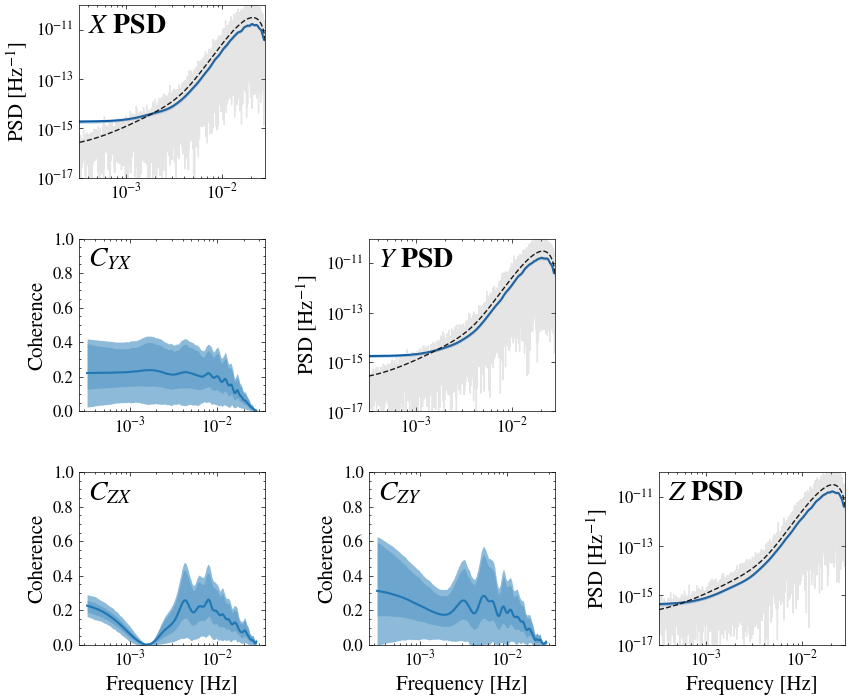

In [44]:
axs = plot_triangle_psd_coherence(
    (optim.uniform_ci)*2/Ew,
    optim.freq,
    channel_labels=['X', 'Y', 'Z'],
)

for i in range(3):
    freq = np.fft.rfftfreq(lisa_data.size, lisa_data.dt)
    axs[i, i].plot(freq, lisa_data.total_model ** 2, color='k', ls='--', lw=1, label='Model')
    # plot the data periodogram
    axs[i, i].plot(optim.pdgrm_freq, optim.pdgrm[..., i, i], color='gray', alpha=0.2, lw=1, label='Data')

    # axs[i,i].legend()
    axs[i, i].set_xlim(FMIN, FMAX)
    axs[i, i].set_ylim(1e-17, 1e-10)
plt.savefig(f"lisa_Nbasis{N_theta}_lr{lr}.png", dpi=300)